# 03 - Análise de Dados Exploratória (EDA)
Autora: Fernanda Baptista de Siqueira  
Curso: MBA em Tecnologia para Negócios – AI, Data Science e Big Data  
Tema: Análise de Acidentes de Trânsito em Porto Alegre (2020–2024)  
Origem DataFrame: Equipe Armazém de Dados de Mobilidade - EAMOB/CIET  
https://dadosabertos.poa.br/dataset/acidentes-de-transito-acidentes (11/05/2025)  

### 1. Importa bibliotecas e funções. Carrega dados

In [3]:
from config import (
    pd, plt, graf_heatmap_cont, graf_heatmap_val,
    graf_contagem, graf_crosstab, 
    graf_temporal, ordenar_dias_semana,
    proporcao_por_veiculo, evolucao_veiculos,
    PATH_CLEAN, COLS_VEICULOS
)
df = pd.read_parquet(PATH_CLEAN + 'df_20_24_chuva.parquet')

### 2. Visualização do Dados
1) Temporal

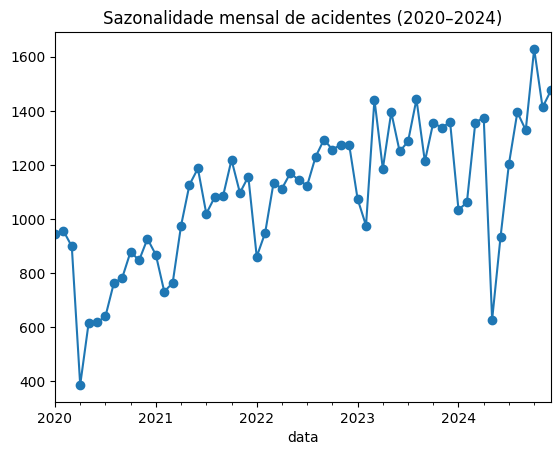

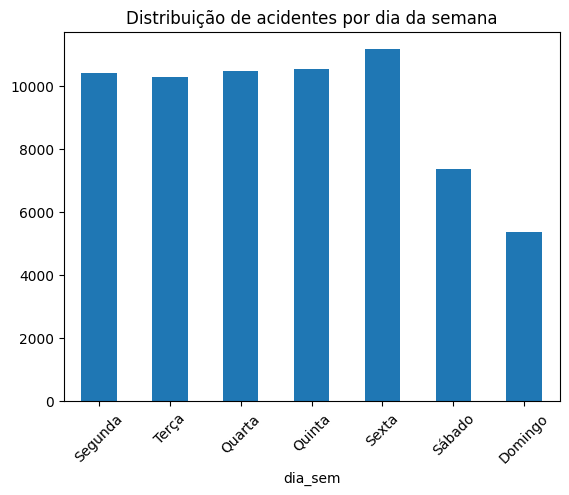

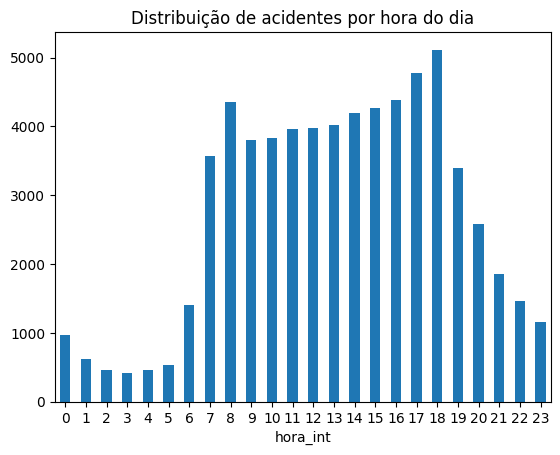

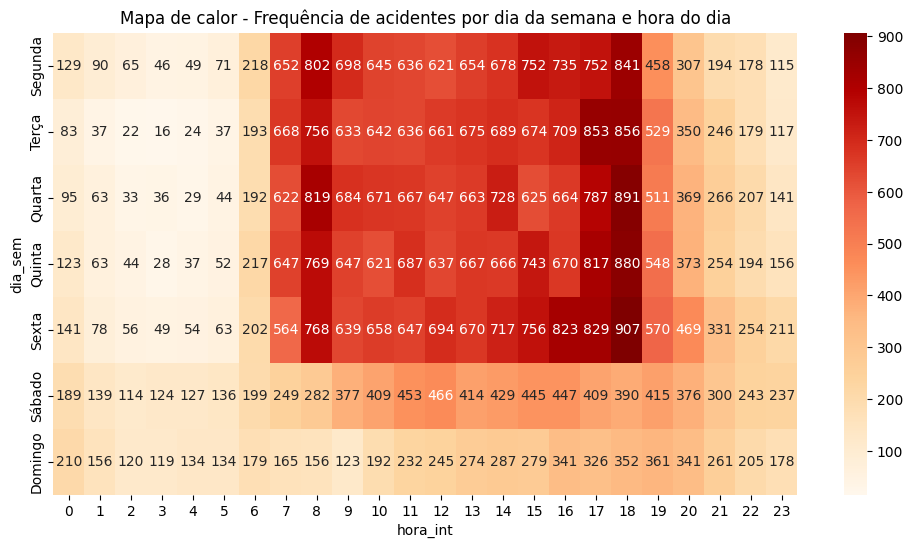

In [11]:
# Sazonalidade mensal
graf_temporal(df, "data", "idacidente", freq="M", titulo="Sazonalidade mensal de acidentes (2020–2024)")

# Dias da semana
df = ordenar_dias_semana(df, "dia_sem")
graf_contagem(df, "dia_sem", "Distribuição de acidentes por dia da semana", rotacao=45, ordenar="indice")

# Horário do dia
graf_contagem(df, "hora_int", "Distribuição de acidentes por hora do dia", ordenar="indice")

# Acidentes por dia da semana e hora do dia
graf_heatmap_cont(
    df,
    eixo_y="dia_sem",
    eixo_x="hora_int",
    titulo="Mapa de calor - Frequência de acidentes por dia da semana e hora do dia",
    largura=12,
    altura=6,
    cmap="OrRd"
)


2. Tipo de Acidentes

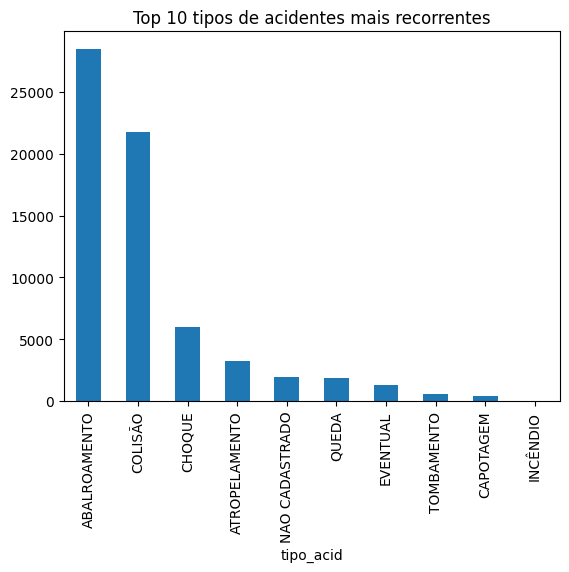

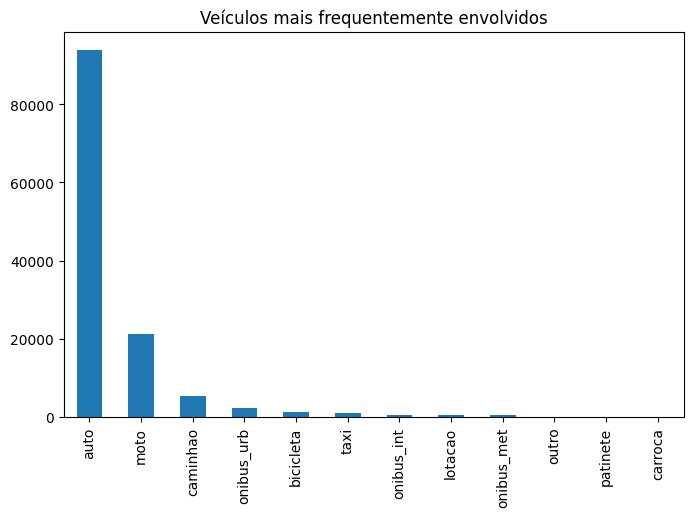

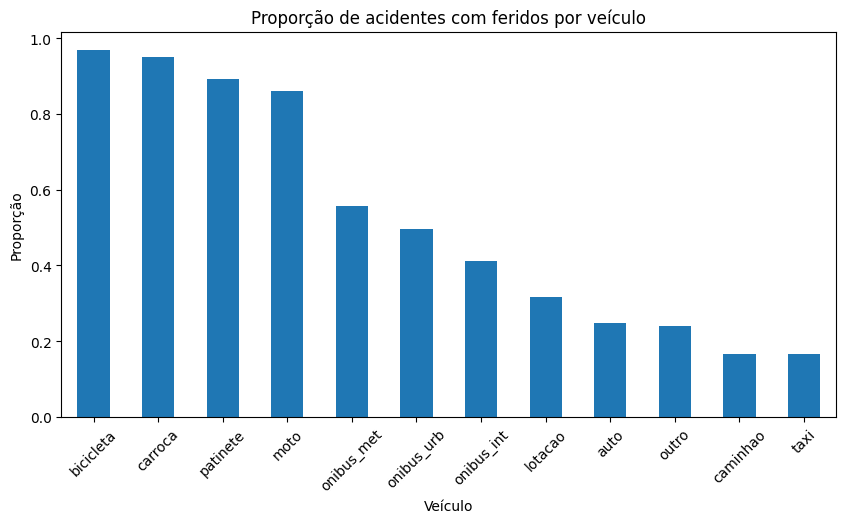

In [ ]:
# Tipos de acidente mais recorrentes
graf_contagem(df, "tipo_acid", "Top 10 tipos de acidentes mais recorrentes", rotacao=90, top=10, ordenar="valor")

# Veículos mais envolvidos
df[COLS_VEICULOS].sum().sort_values(ascending=False).plot(kind="bar", figsize=(8,5))
plt.title("Veículos mais frequentemente envolvidos")
plt.show()

# Veículos com maior número de vítimas
proporcao_por_veiculo(df, COLS_VEICULOS, alvo="feridos", titulo="Proporção de acidentes com feridos por veículo")


3. Localização

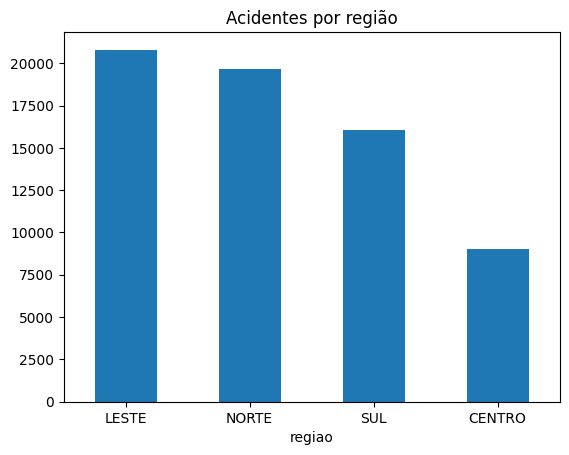

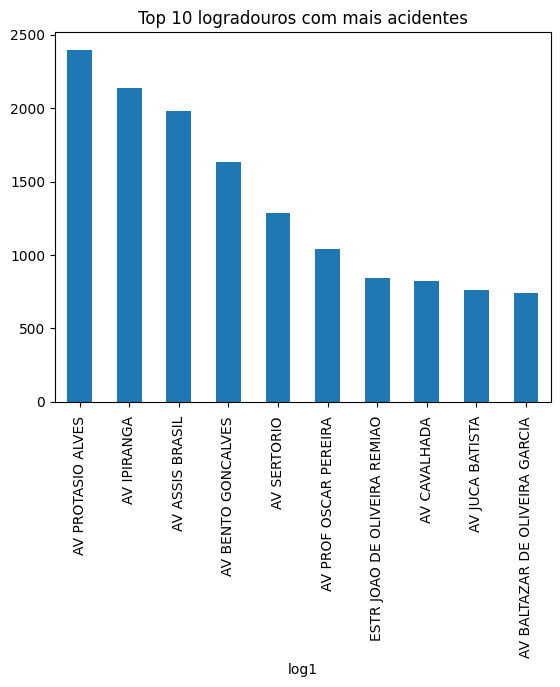

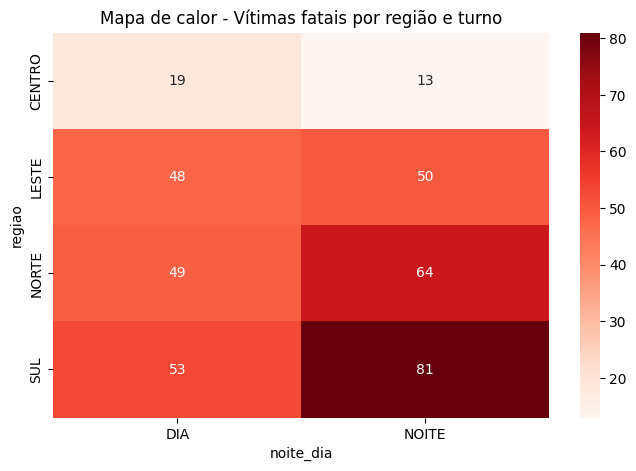

In [6]:
# Acidentes por região
graf_contagem(df, "regiao", "Acidentes por região")

# Hotspots (top 10 logradouros)
graf_contagem(df, "log1", "Top 10 logradouros com mais acidentes", rotacao=90, top=10)

graf_heatmap_val(
    df,
    eixo_y="regiao",
    eixo_x="noite_dia",
    valor="fatais",
    aggfunc="sum",
    titulo="Mapa de calor - Vítimas fatais por região e turno",
    largura=8,
    altura=5,
    cmap="Reds"
)


4. Condições Externas

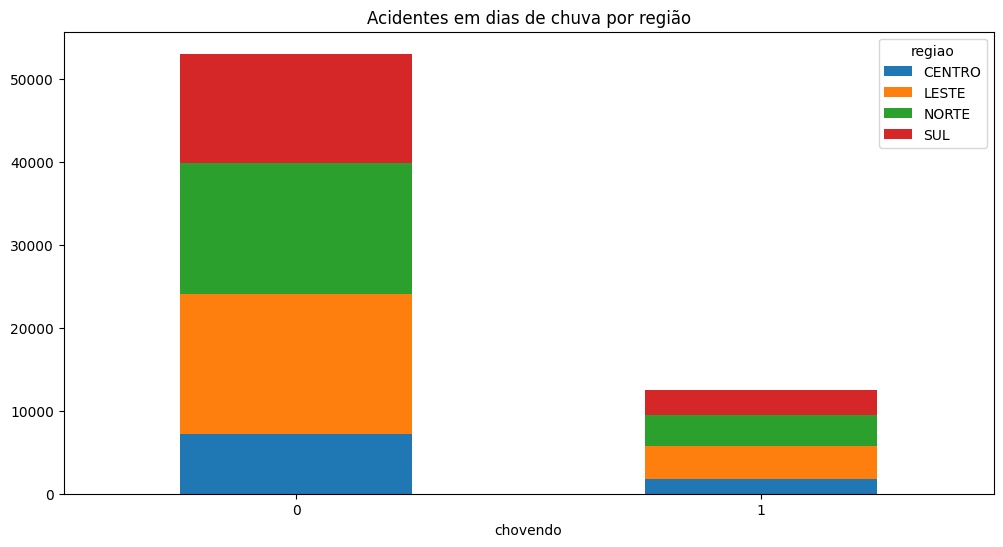

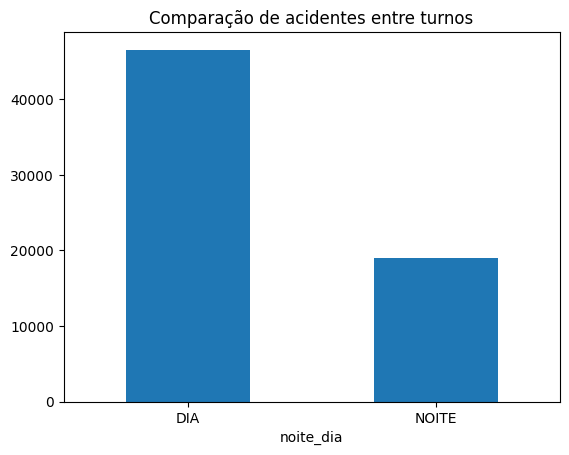

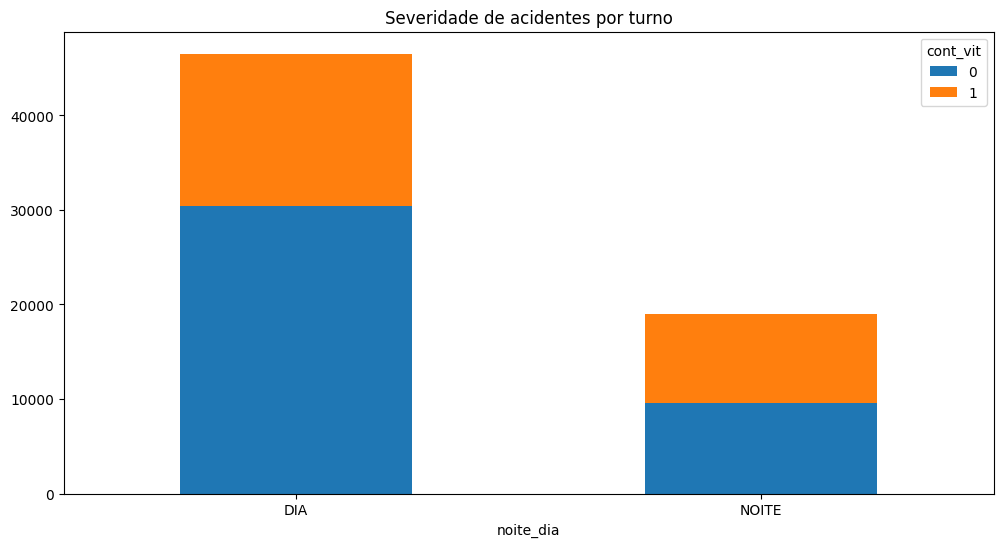

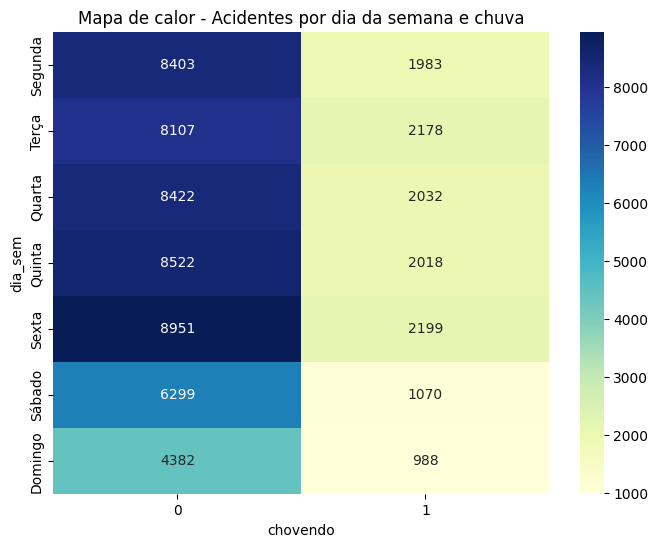

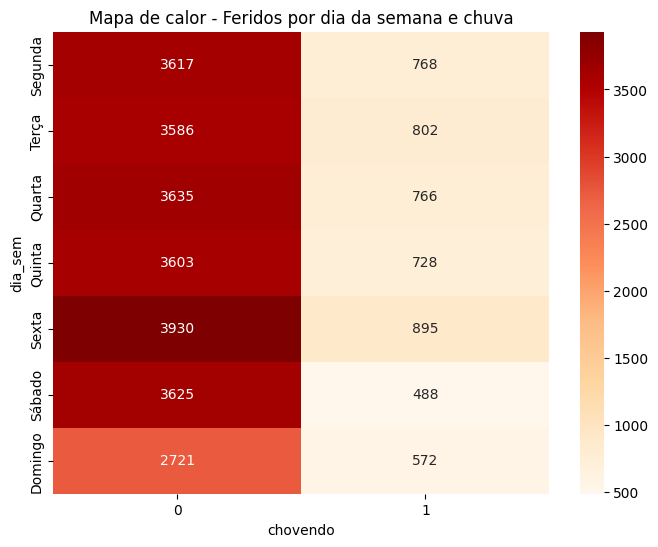

In [7]:
# Acidentes em dias de chuva
graf_crosstab(df, "chovendo", "regiao", "Acidentes em dias de chuva por região")

# Turno diurno x noturno
graf_contagem(df, "noite_dia", "Comparação de acidentes entre turnos")

# Severidade por turno
graf_crosstab(df, "noite_dia", "cont_vit", "Severidade de acidentes por turno")

# Chuva × Dia da semana
# Ajuda a verificar se em finais de semana chuvosos os acidentes aumentam.
graf_heatmap_cont(
    df,
    eixo_y="dia_sem",
    eixo_x="chovendo",
    titulo="Mapa de calor - Acidentes por dia da semana e chuva",
    largura=8,
    altura=6,
    cmap="YlGnBu"
)


# Chuva × Turno (dia/noite) 
# Mostra se a severidade aumenta mais à noite em dias chuvosos.
graf_heatmap_val(
    df,
    eixo_y="dia_sem",
    eixo_x="chovendo",
    valor="feridos",
    aggfunc="sum",
    titulo="Mapa de calor - Feridos por dia da semana e chuva",
    largura=8,
    altura=6,
    cmap="OrRd"
)


5. Envolvidos

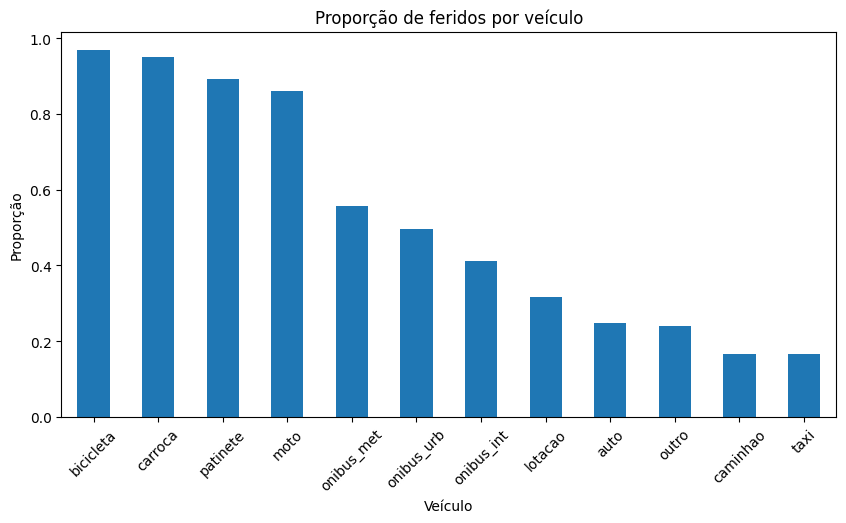

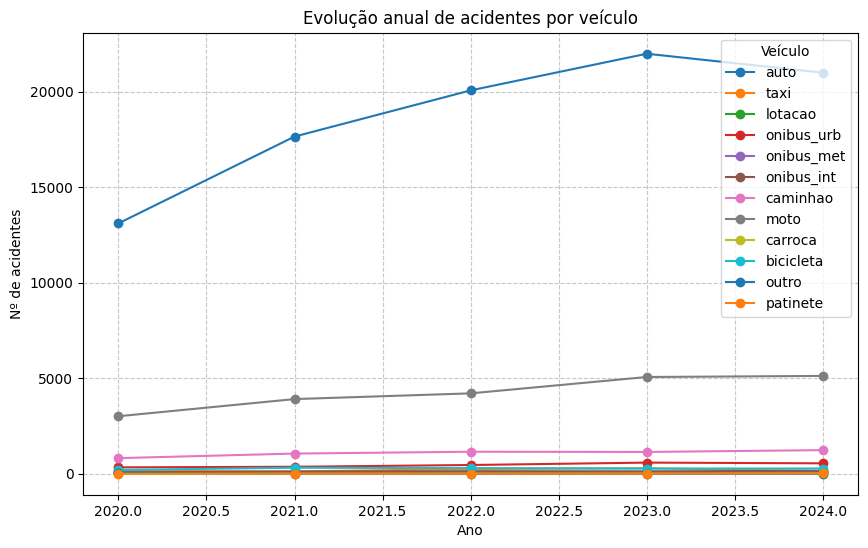

In [9]:
# Proporção de feridos por veículo
proporcao_por_veiculo(df, COLS_VEICULOS, alvo="feridos", titulo="Proporção de feridos por veículo")

# Tendência de crescimento ao longo do período
evolucao_veiculos(df, COLS_VEICULOS, titulo="Evolução anual de acidentes por veículo")


6. Severidade

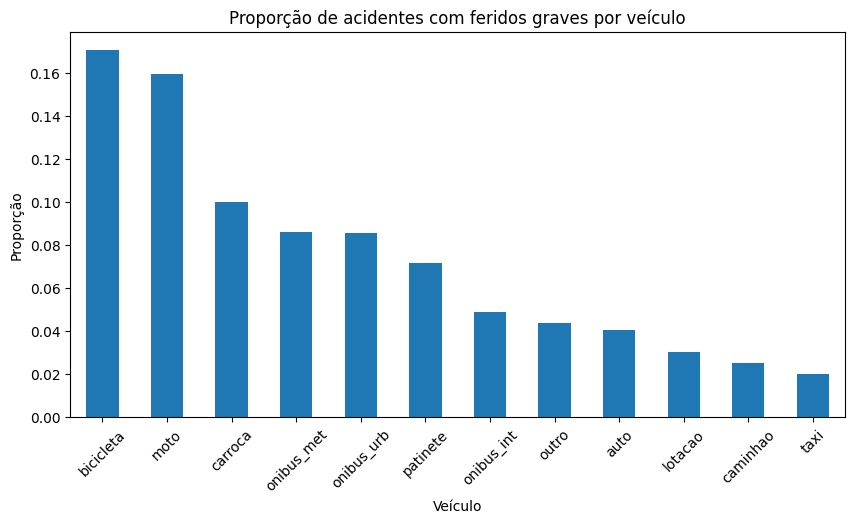

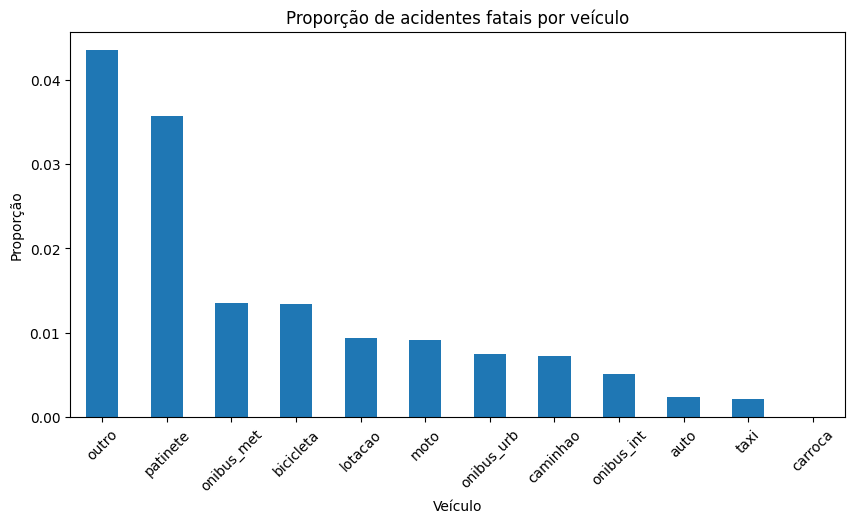

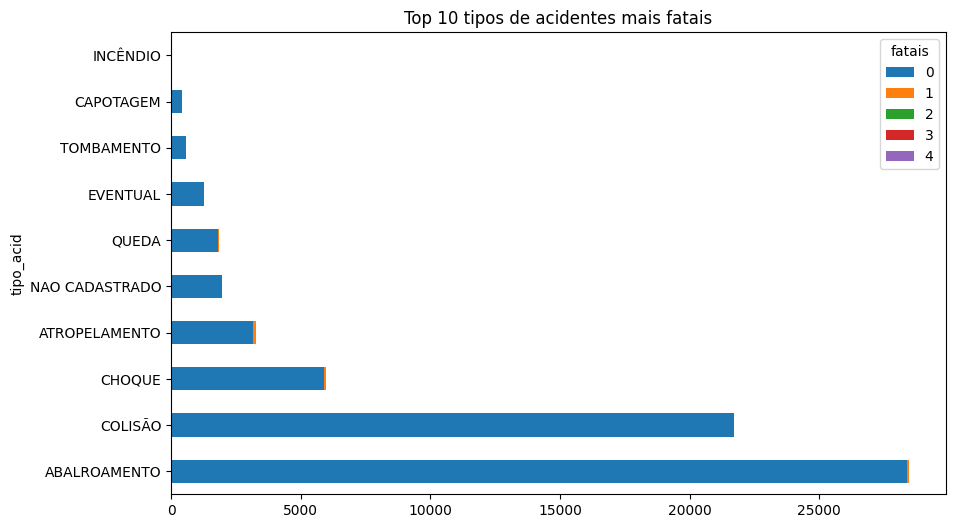

In [10]:
# Nível geral de gravidade
df[["feridos","feridos_gr","fatais"]].sum()

# Veículos mais associados a ocorrências graves
proporcao_por_veiculo(df, COLS_VEICULOS, alvo="feridos_gr", titulo="Proporção de acidentes com feridos graves por veículo")

# Veículos e tipos de acidentes mais fatais
proporcao_por_veiculo(df, COLS_VEICULOS, alvo="fatais", titulo="Proporção de acidentes fatais por veículo")

# Mostrar apenas os 10 tipos mais fatais, em gráfico horizontal
graf_crosstab(df, "tipo_acid", "fatais", "Top 10 tipos de acidentes mais fatais",
              empilhado=True, horizontal=True, top=10)
